In [375]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln, cost_functions
from neurolib.experiments.WPtwo.onen.plot import plot_1n_osc, plot_1n_osc_noisy

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state


while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')
    
pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/1n")
dir = os.path.join(pickledir, "images_1n_aln")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
coords = [[1., 1.], [2.2, 1.]]

data = dict()
data["coordinates"] = [coords[0], coords[1]]
data["control"] = [None , None]
data["state"] = [None , None]
data["init_state"] = [None , None]

N = 1
model = ALNModel()
dt = model.params.dt

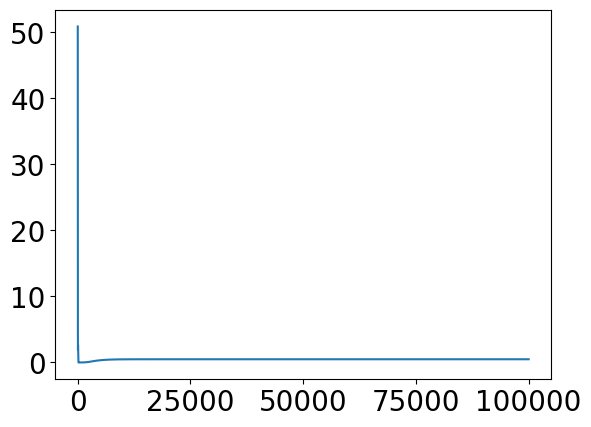

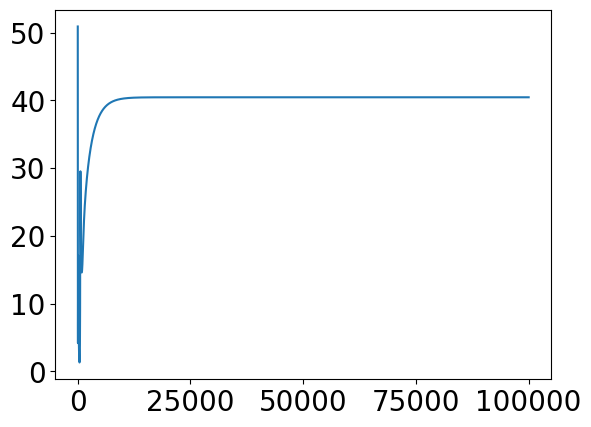

In [247]:
model = ALNModel()
testd = 1e4
model.params.duration = testd
model.params.dt = dt

for ci in range(2):
    model.params.mue_ext_mean = data["coordinates"][ci][0]
    model.params.mui_ext_mean = data["coordinates"][ci][1]

    model.run()

    plt.plot(model.rates_exc[0,:])
    plt.show()

    data["init_state"][ci] = getfinalstate(model)

In [249]:
from numba.typed import Dict
from numba.core import types

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

controlmat = np.zeros((N,4))
controlmat[0,0] = 1

costmat = np.zeros((N, 3))
costmat[:,0] = 1.

duration = 400.
target_period = 30

int0 = 500
int1 = 3500

model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

it = 5
maxstr = 5
pr = np.arange(0,101,10)

In [323]:
data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -5.94333294783587
Final cost : -5.94333294783587
Compute control for a deterministic system
Cost in iteration 0: -5.94333294783587
Converged in iteration 8 with cost -5.943353487295326
Final cost : -5.943353487295326
Compute control for a deterministic system
Cost in iteration 0: -5.943353487295326
Converged in iteration 1 with cost -5.943353487295326
Final cost : -5.943353487295326
Compute control for a deterministic system
Cost in iteration 0: -5.943353487295326
Converged in iteration 1 with cost -5.943353487295326
Final cost : -5.943353487295326
Compute control for a deterministic system
Cost in iteration 0: -5.943353487295326
Converged in iteration 1 with cost -5.943353487295326
Final cost : -5.943353487295326
Compute control for a deterministic system
Cost in iteration 0: -5.943353487295326
Converged in iteration 1 with cost -5.943353487295326
Final cost : -5.943353487295

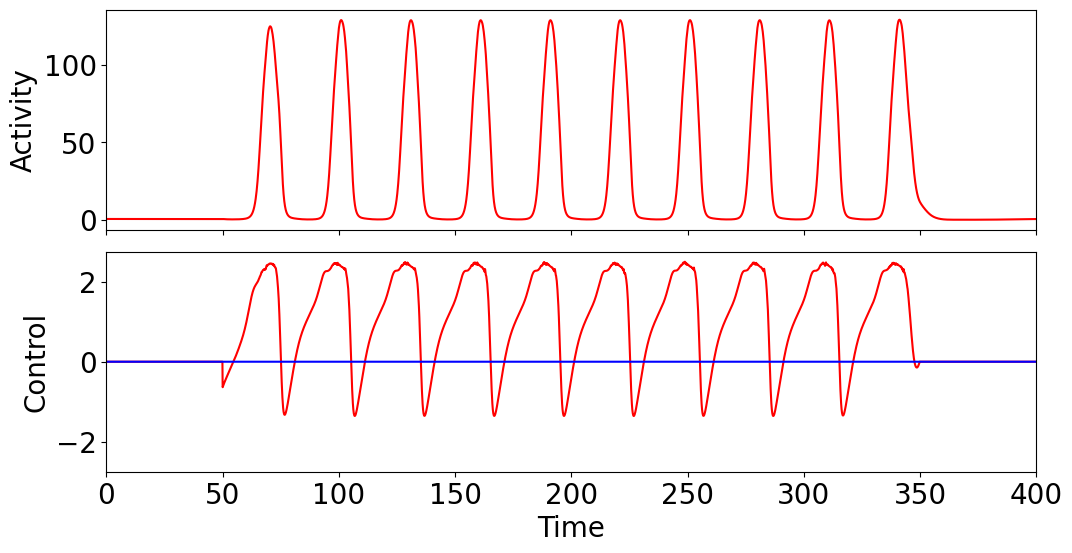

In [324]:
ci = 0

it = 100
w2 = 1.8

model = ALNModel()
setinitstate(model, data["init_state"][ci])
model.params["mue_ext_mean"] =  data["coordinates"][ci][0]
model.params["mui_ext_mean"] =  data["coordinates"][ci][1]
model.params.duration = duration

model.run()


model.params["ext_exc_current"] = zero_control[:,0,:]
model.params["ext_inh_current"] = zero_control[:,1,:]

for factor in [1]:
#for factor in 4. * np.random.random(10):

    model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2 * factor
    model_controlled.weights["w_f"] = 1.

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(data["control"][ci]) != type(None):
            model_controlled.control = data["control"][ci]
            #model_controlled.control[:,0,:4000] = 0
            model_controlled.update_input()

    if False:
        init_osc = 0.8 * (1. - np.cos(2.*np.pi*np.arange(0,300, dt)/target_period))
        model_controlled.control[0,0,int0:int1] = init_osc
        model_controlled.update_input()

    model_controlled.optimize(0)
    
    for j in range(1):
        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True

        for l in range(0):
            for k in [13]:
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        for l in range(1):
            for k in np.arange(-3., 3., 1.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)
        
        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-4., 5., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    #data["control"][ci] = model_controlled.control.copy()
    #data["state"][ci] = model_controlled.get_xs()

#print("cost of control = ", cost_functions.control_strength_cost(data["control"][fi][wi], weights, dt))
plot_control_1(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

In [386]:
data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -19.762927078701665
Final cost : -19.762927078701665
Compute control for a deterministic system
Cost in iteration 0: -19.762927078701665
Converged in iteration 1 with cost -19.762927078701665
Final cost : -19.762927078701665
Compute control for a deterministic system
Cost in iteration 0: -19.762927078701665
Converged in iteration 1 with cost -19.762927078701665
Final cost : -19.762927078701665
Compute control for a deterministic system
Cost in iteration 0: -19.762927078701665
Converged in iteration 1 with cost -19.762927078701665
Final cost : -19.762927078701665
Compute control for a deterministic system
Cost in iteration 0: -19.762927078701665
Converged in iteration 1 with cost -19.762927078701665
Final cost : -19.762927078701665
Compute control for a deterministic system
Cost in iteration 0: -19.762927078701665
Converged in iteration 1 with cost -19.762927078701665
Final cos

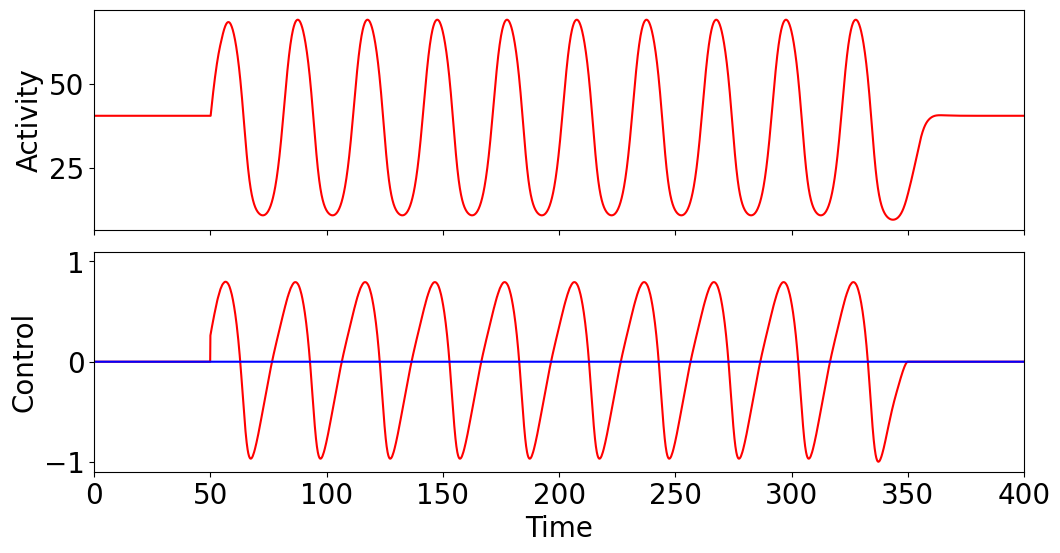

In [385]:
ci = 1
it = 20
w2 = 4
      
model = ALNModel()
setinitstate(model, data["init_state"][ci])
model.params["mue_ext_mean"] =  data["coordinates"][ci][0]
model.params["mui_ext_mean"] =  data["coordinates"][ci][1]
model.params.duration = duration

model.run()

model.params["ext_exc_current"] = zero_control[:,0,:]
model.params["ext_inh_current"] = zero_control[:,1,:]

for factor in [1]:
#for factor in 4. * np.random.random(10):

    model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2 * factor
    model_controlled.weights["w_f"] = 1.

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(data["control"][ci]) != type(None):
            model_controlled.control = data["control"][ci]
            #model_controlled.control[:,0,:4000] = 0
            model_controlled.update_input()

    if False:
        init_osc = 0.6 * (1. - np.cos(2.*np.pi*np.arange(0,150, dt)/target_period))
        model_controlled.control[0,0,int0:int1] = init_osc
        model_controlled.update_input()

    model_controlled.optimize(0)
    
    for j in range(1):
        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True


        for l in range(1):
            for k in np.arange(-5., 5., 1.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        print(np.amax(np.abs(model_controlled.gradient)))
        
        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-6., 7., 3.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    data["control"][ci] = model_controlled.control.copy()
    data["state"][ci] = model_controlled.get_xs()

#print("cost of control = ", cost_functions.control_strength_cost(data["control"][fi][wi], weights, dt))
plot_control_1(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

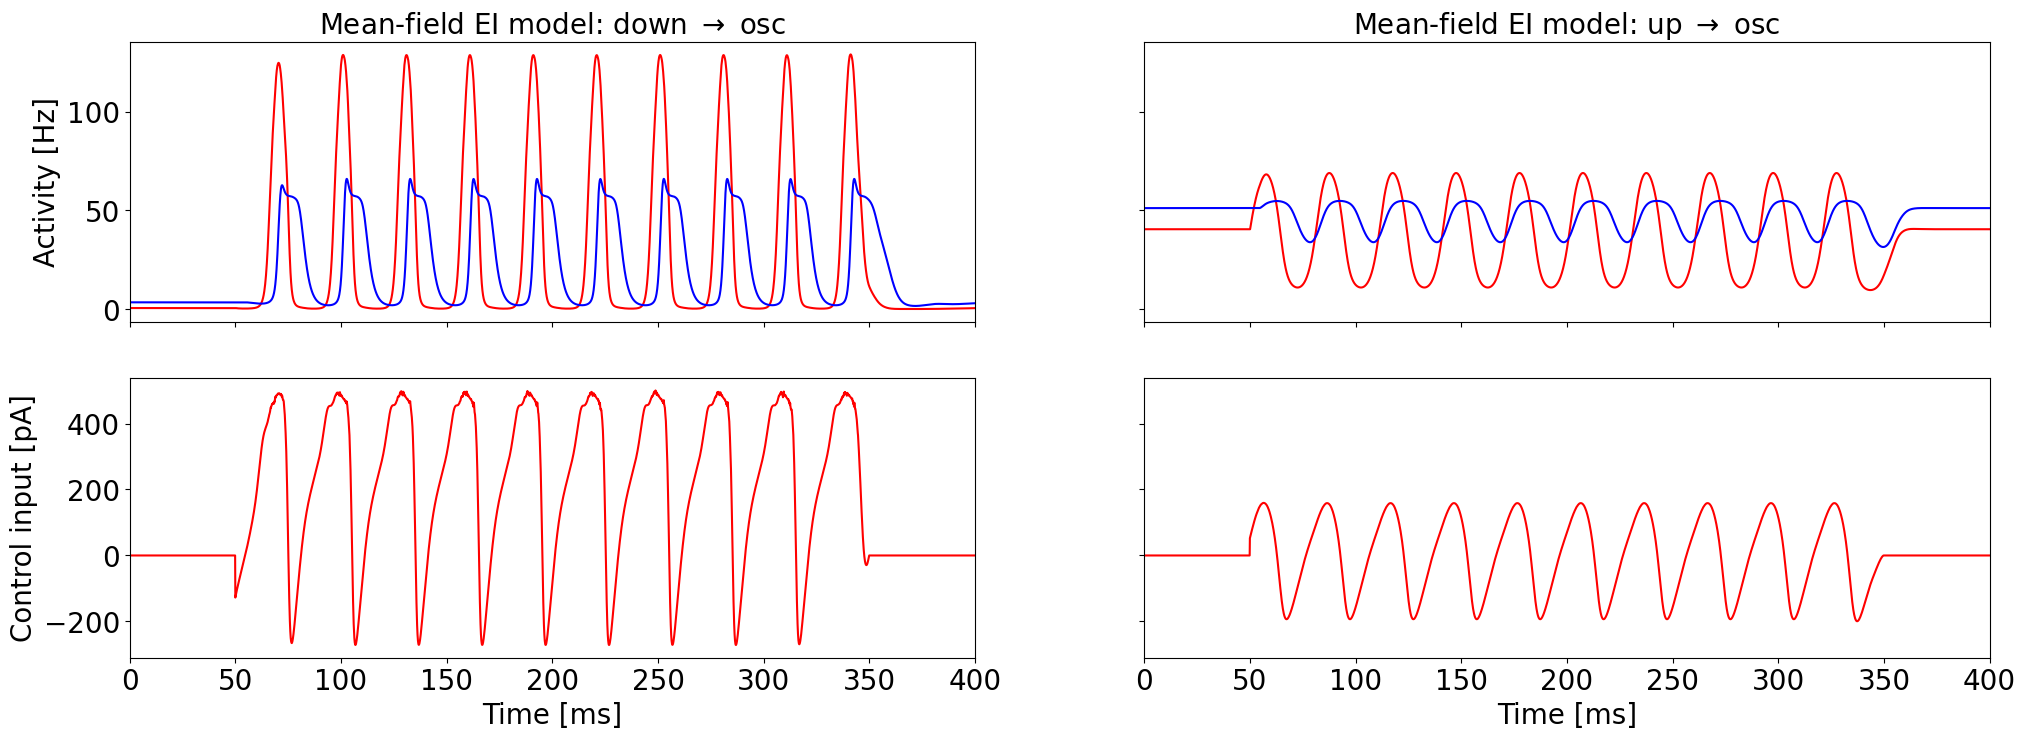

In [390]:
fig, ax = plt.subplots(2,2, figsize=(24,8), sharex=True, sharey="row")

ax[0,0].set_title(r"Mean-field EI model: down $\rightarrow$ osc")
ax[0,1].set_title(r"Mean-field EI model: up $\rightarrow$ osc")

time = np.arange(0, duration+dt, dt)

for ci in range(2):
    ax[0,ci].plot(time, data["state"][ci][0,0,:], color="red", label="E")
    ax[0,ci].plot(time, data["state"][ci][0,1,:], color="blue", label="I")
    ax[1,ci].plot(time, 200*data["control"][ci][0,0,:], color="red")

ax[0,0].set_label("upper right")

ax[1,0].set_xlabel("Time [ms]")
ax[1,1].set_xlabel("Time [ms]")
ax[0,0].set_ylabel("Activity [Hz]")
ax[1,0].set_ylabel("Control input [pA]")

ax[0,0].set_xlim(0, duration)


plt.savefig(os.path.join(dir, "aln_stat_osc.pdf"), bbox_inches='tight')

In [6]:
def plot_control_1(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0].plot(time_array, s[n,0,:], color="red")
        ax[1].plot(time_array, c[n,0,:], color="red")
        ax[1].plot(time_array, c[n,1,:], color="blue")

    ax[0].set_xlim(0, dur)

    ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [388]:
with open(os.path.join(pickledir, 'osc_1n_aln_static_osc.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [124]:
with open(os.path.join(pickledir, 'osc_1n_aln_static_osc.pickle'), 'rb') as f:
    res_read = pickle.load(f)

data = res_read.copy()